# Metody uczenia maszynowego 2017 - Regresja, ciąg dalszy

<h3 id=tocheading>Spis treści</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("fivethirtyeight")

 "And here's to you, <span style="background-color:green">Mrs. Robinson</span>, <span style="color:red">Jesus</span> loves you more than you will know."

In [3]:
from __future__ import print_function, unicode_literals

import numpy as np
from scipy import stats
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score
from sklearn.metrics import classification_report, matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing

from sklearn.datasets import load_boston, load_diabetes, load_linnerud
from sklearn.datasets import make_regression
from sklearn.datasets import make_friedman1, make_friedman2, make_friedman3
from sklearn.datasets import make_sparse_uncorrelated
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.linear_model import BayesianRidge, LinearRegression

In [4]:
from astroML.datasets import fetch_imaging_sample
from sklearn.preprocessing import PolynomialFeatures
from astroML.cosmology import Cosmology
from astroML.datasets import generate_mu_z

# Metody regresji bayesowskiej

> Thomas Bayes napisał pracę _jak łączyć wstępne przekonanie z nowymi danymi_ opublikowaną pośmiertnie w 1763

> Laplace odkrył ją na nowo, wyjaśnił szczegółowo, podał przykłady, np. pokazał jak policzyć masę Saturna bez bezpośrednich pomiarów ("...mogę podać zaklad jak jeden do 11 tysięcy, że podana masa nie różni się więcej niż o jedną setną od prawdziwej...")

> metoda Bayesowska pokazana i wyjaśniona na nowo w 20 wieku

* Likelihood $$L=p(D|M,\theta)=\prod_{i=1}^N p(x_i\mid M,\theta)$$
  * $L$ nie jest poprawnie znormalizowane do $1$; iloczyn może przyjąć bardzo
  niskie wartości
  * likelihood _dla ustalonych danych_ traktować jako funkcję parametrów modelu
  * potrzebna analiza bayesowska by móc __interpretować likelihood jako
  prawdopodobieństwa dla parametrów__

## Problem na przystanku klasycznie
1. przychodzimy na przystanek, nie znając rozkładu jazdy
2. autobus odjeżdża po $t$ minutach
3. jaki jest średni czas $\tau$ między autobusami (jeżdżą punktualnie)?



### Intuicyjnie
1. czas oczekiwania jest równomierny w przedziale $0\leq t\leq\tau$
2. średnio oczekujemy $t=\tau/2$ minut
3. stąd $$\tau=2t$$ co jest zgodne z intuicją


### Likelihood
1. oczekiwanie $t$ jest z rozkladu równomiernego
$$p(t|\tau)=\begin{cases}1/\tau\hskip{3ex}0\leq t\leq\tau\\0\hskip{4ex}\text{wpp}\end{cases}$$
co odpowiada likelihood danych
2. poniważ mamy tylko jeden punkt danych, stąd $$L=\prod_i p(x_i|\tau)=1/\tau$$
3. korzystając z __maximum likelihood__ szukamy $\tau$ dającego największe prawdopodobieństwo
  1. odpowiedzią jest __najmniejsze__ $\tau\geq t$
  2. to daje $\tau=t$  co jest __sprzeczne__ z intuicją
  
  
__Potrzeba dodać jakąś informację__

## Kluczowe elementy
* reguła Bayesa $$ P(M \mid D) = \frac{P(D \mid M) \, P(M)}{P(D)} $$
  * łączy wstępne przekonanie (__belief__) z nowymi danymi
  * nowo wyliczone przekonanie można użyć jak początkowe, gdy pojawią się nowe dane
  
$$\boxed{\begin{align}
P(M,\theta\mid D,I)&=\frac{P(D,I\mid M,\theta)\,P(M,\theta\mid I)}{P(D,I)}\\
&=\frac{P(D\mid M,\theta, I)\,P(I)\,P(M,\theta\mid I)}{P(D\mid I)\,P(I)}\\
&=\frac{P(D\mid M,\theta, I)\,P(M,\theta\mid I)}{P(D\mid I)}\\
&=\frac{P(D\mid M,\theta, I)\,P(\theta\mid M,\,I)\,P(M\mid I)}{P(D\mid I)}
\end{align}\;}$$
  * $P(M,\theta\mid D,I)$: __posterior__ rozkład prawdopodobieństwa moelu i parametrów pod warunkiem danych
  * $P(D\mid M,\theta, I)$: __lieklihood__ danych pod warunkiem modelu oraz __ustalonych__ parametrów $\theta$
  * $P(M,\theta\mid I)$: __prior__ rozklad prawdopodobieństwa modelu i parametrów bez jakichkolwiek danych
    * prior może powstawać gdy już są dane (logiczny)
  * $P(D\mid I)$: prawdopodobieństwo danych
    * daje generalizację
    * nie ma konieczności wyliczania
      * zwykle wystarczy zrenormalizować posterior

### Znowu na przystanku
$$p(t|\tau)=\begin{cases}1/\tau\hskip{3ex}0\leq t\leq\tau\\0\hskip{4ex}\text{wpp}\end{cases}$$ odpowiada likelihood $P(D\mid M,\theta, I)$

(jedncześnie $P(M, \theta\mid I)=P(\theta\mid M, I)\,P(M\mid I)$)
* niech prior $$p(\tau\mid I)=1/\tau$$
Stąd 
$$\begin{align}
P(M,\theta\mid D,I)=p(\tau\mid t,I)&=\frac{\overbrace{p(t\mid\tau,I)}^{likelihood: 1/\tau}\, \overbrace{p(\tau\mid I)}^{prior: 1/\tau}\, p(M\mid I)}{p(t\mid I)}\\
&=\frac{\tau^{-2}\,p(M\mid I)}{p(t\mid I)}
\end{align}$$
* normalizacja do jedności daje
$$p(\tau\mid t,I)=\begin{cases}t/\tau^{2}\hskip{3ex}t\leq\tau\\
0\hskip{4ex}\text{wpp}\end{cases}$$
* mediana $\tau$ dla posterior jest równa $2t$

* zgodne z intuicją

## Kroki algorytmu Bayesowskiego
1. określenie likelihood $P(D\mid M, I)$
  * każdy jest dobry
  * słaby likelihood da słabszy posterior
2. wybór prior $P(\theta\mid M, I)$
  * zawiera inną dostępną wiedzę
    * nie wykorzystywane w liczeniu likelihood pomiary
    * wiedzę ogólną, tzw. _uninformative_ prior
3. wyliczenie posterior $P(M\mid D, I)$
  * złożone obliczeniowo
  * zykle posterior normalizowany __bez__ liczenia $P(D\mid I)$
4. poszukiwanie najlepszych parametrów modelu maksymalizujacych posterior $P(M\mid D, I)$ dając oszacowanie __maximum a posteriori__ (__MAP__)
5. określenie przedziałów pewności
  * określenie takich $a, b$, że
  $$\int_{-\infty}^{a}f(\theta)d\theta=\int_{b}^{\infty}f(\theta)d\theta=\alpha/2$$
    * wtedy prawdopodobieństwo, że prawdziwa wartość leży w $(a, b)$ wynosi $1-\alpha$
  * analityczne jeśli model pozwala
    * problem przystanku daje $1.03<t<40$ minut z pewnością 95%
  * w przeciwnym przypadku próbkowanie z posterior
    * analogiczne do bootstrap
6. testowanie hipotez o modelu i parametrach

<img src="../mum_figures/bayes-bishop.png" width="100%"/>[rysunek za Bishop]

## Priory
* __uninformative__ jeśli nie mamy żadnych informacji o danych
  * ale może zawierać pewne założenia o modelu
* równomierny $$p(\theta\mid I)\propto C$$ gdzie $C$ jest stałą
  * niepoprawny, bo nie sumuje się do $1$
  * inne elementy posterior mogą kontrolować, i wtedy możliwy
  * można określić na zakresie
* zwykle priory powinny być zgodne z pewnymi regułami
  * __niezależności__  podstawowe wzajemnie niezależne szanse powinny mieć przypisane równe prawdopodobieństwo
      * przy braku innych informacji
      * na przykład szanse scianek kostki
  * __spójności__ prior dla parametrów położenia powinny być niezależne od translacji układu współrzędnych
  * __niezależności od jednostek__ przeskalowanie do innych jednostek nie powinny zmieniać prioru $$p(\sigma\mid I)d\sigma=p(a\sigma\mid I)d(a\sigma)$$
      co daje $p(\sigma\mid I)\propto\sigma^{-1}$
      * przypadek przystanku!

<img src="../mum_figures/predictiveDistributionBayes.png" width="100%"/>[rysunek za Bishop]

<img src="../mum_figures/predictiveDistributionBayesValues.png" width="100%"/>[rysunek za Bishop]

In [5]:
def tryBayesianRidge():
    np.random.seed(0)
    n_samples, n_features = 100, 100
    X = np.random.randn(n_samples, n_features)  # Create Gaussian data
    # Create weights with a precision lambda_ of 4.
    lambda_ = 4.
    w = np.zeros(n_features)
    # Only keep 10 weights of interest
    relevant_features = np.random.randint(0, n_features, 10)
    for i in relevant_features:
        w[i] = stats.norm.rvs(loc=0, scale=1. / np.sqrt(lambda_))
    # Create noise with a precision alpha of 50.
    alpha_ = 50.
    noise = stats.norm.rvs(loc=0, scale=1. / np.sqrt(alpha_), size=n_samples)
    # Create the target
    y = np.dot(X, w) + noise
    
    print("alpha = {:9.6f}, lambda = {:9.6f}".format(1.e-6, 1.e-6))
    clf = BayesianRidge(compute_score=True, normalize=True)
    clf.fit(X, y)
    print("alpha = {:9.6f}, lambda = {:9.6f}".format(clf.alpha_, clf.lambda_))
    print("score = {}".format(clf.scores_))

    ols = LinearRegression()
    ols.fit(X, y)
    
    lw = 2
    plt.figure(figsize=(20, 10))
    plt.title("Weights of the model")
    plt.plot(clf.coef_, color='lightgreen', linewidth=lw,
             label="Bayesian Ridge estimate")
    plt.plot(w, color='gold', linewidth=lw, label="Ground truth")
    plt.plot(ols.coef_, color='navy', linestyle='--', label="OLS estimate")
    plt.xlabel("Features")
    plt.ylabel("Values of the weights")
    plt.legend(loc="best", prop=dict(size=12))

    plt.figure(figsize=(20, 10))
    plt.title("Histogram of the weights")
    plt.hist(clf.coef_, bins=n_features, color='gold', log=True)
    plt.scatter(clf.coef_[relevant_features], 5 * np.ones(len(relevant_features)),
                color='navy', label="Relevant features")
    plt.ylabel("Features")
    plt.xlabel("Values of the weights")
    plt.legend(loc="upper left")

    plt.figure(figsize=(20, 10))
    plt.title("Marginal log-likelihood")
    plt.plot(clf.scores_, color='navy', linewidth=lw)
    plt.ylabel("Score")
    plt.xlabel("Iterations")
    plt.show()

alpha =  0.000001, lambda =  0.000001
alpha = 49.158861, lambda =  0.751893
score = [-59.58853683604007, -16.637303877757184, 4.3505165868355773, 35.556374330130474, 72.850020334211706, 110.60280067894277, 142.83377646527302, 165.92354606362423, 180.06338821707939, 187.77811473342143, 191.70183470283033, 193.62467519411047, 194.54993451587345, 194.99130069707377, 195.20097320262789, 195.30038446264459, 195.34747442356351, 195.36977064031359, 195.38032529810266, 195.38532120808415]


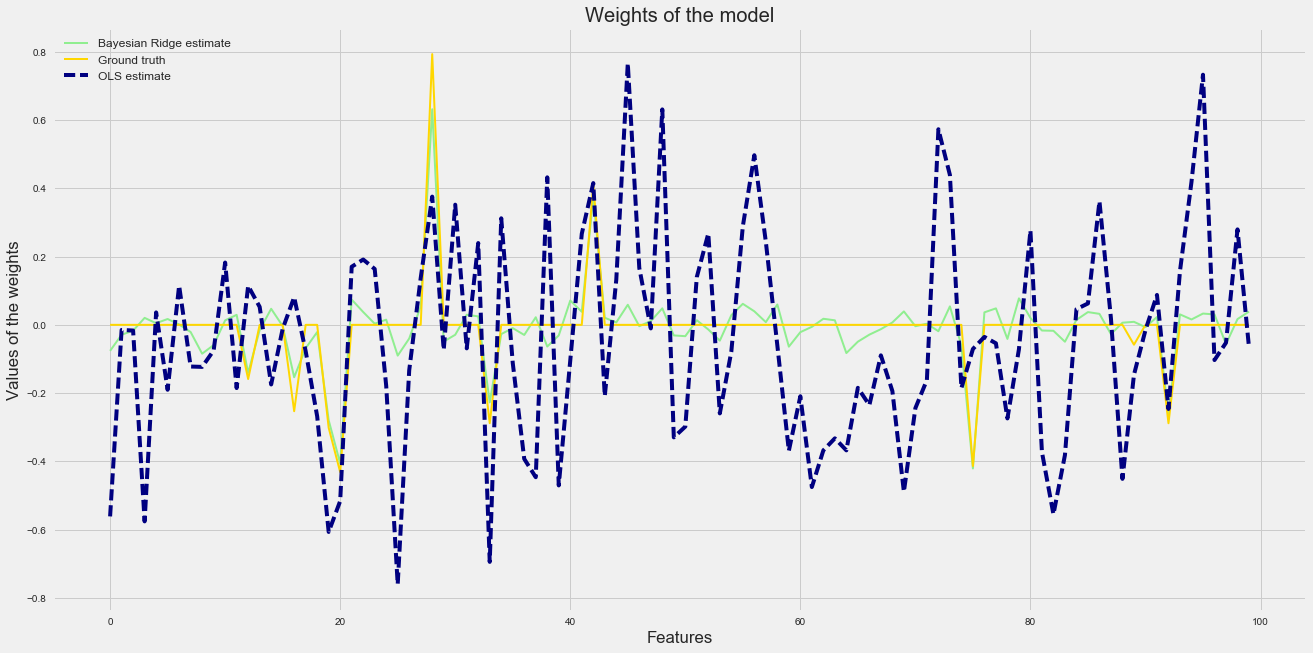

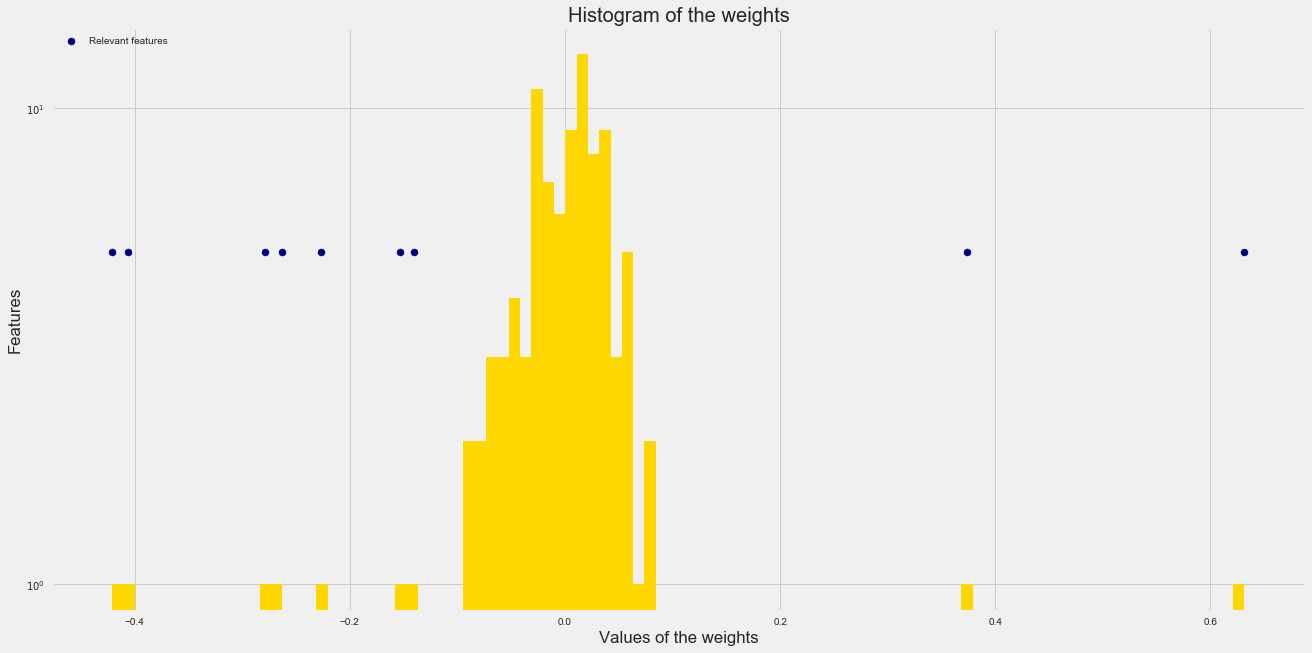

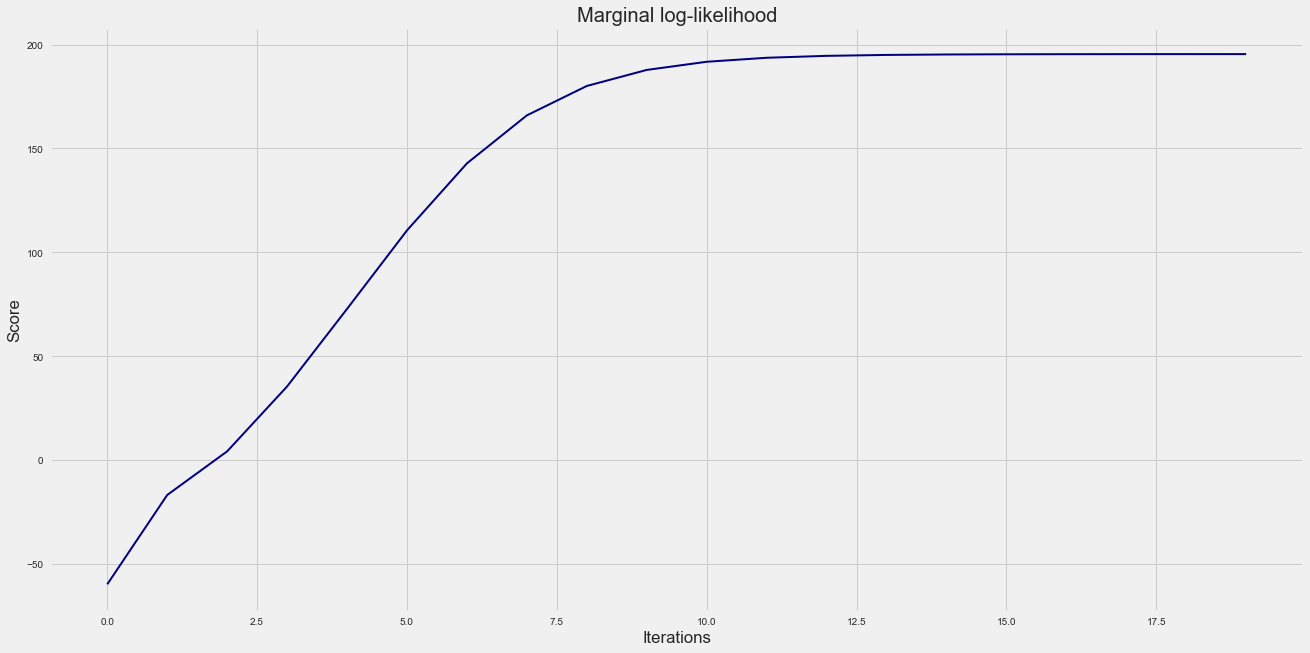

In [6]:
tryBayesianRidge()

# Znowu regularyzacja

* jeśli wiemy, ze błędy pomiarów mają rozkład gausowski, to wykorzystujemy normę $L_2$
* jesli błąd ma rozkład wykładniczy 
$$p(x\mid \mu,\delta)=\frac{1}{2\delta}\exp\left(-\frac{|x-\mu|}{\delta}\right)$$
to stosowac należy normę $L_1$

* przy regresji bayesowskiej zamiast dodatkowego składnika kosztu należy użyć odpowiedni prior
  * prior wprowadza ograniczenia na parametry
  $$p(\theta\mid I)\propto\exp\left(-\frac{-\lambda\theta^T\theta}{2}\right)$$
  który da rezultat równoważny z MLE z ridge
  * dla Lasso równoważny będzie
  $$p(\theta\mid I)\propto\exp\left(-\frac{|\lambda\theta|}{2}\right)$$

### Jak dobrać $\lambda$
* większe $\lambda$ zwiększa ograaniczenia
  * elementy na przekątnej macierzy wartośi własnych tracą istotność
  * przy większym $\lambda$ w rozwiązaniu pozostają najważniejsze skladowe
  
* wykorzystać k-krotną walidację krzyżową
$$\begin{align}
Err(\lambda)&=\frac{1}{k}\sum_k N_k^{-1}\sum_i^{N_k}\frac{\left(y_i-f(x_i\mid\theta)\right)^2}{\sigma_i^2}\\
\lambda&=\underset{\lambda'}{\arg\min}Err(\lambda')
\end{align}$$
gdzie $N_k^{-1}$ to liczba przykładów w k-tym foldzie

# Regresja nie całkiem liniowa
* modele liniowe rozwiązują prolemy calościowo
* transformacja danych jest wygodnym trikiem, czasem wprowadza problemy
* są modele nieliowe, bardziej zlożone


## Nadaraya-Watson 
* definiuje __lokalną__ funkcję __kernel__ $K(x_i, x)$
  * amplituda zależna jedynie od odleglosci od wszystkich punktów
  * dodatnia
  * malejąca do zera wraz z odległością
  * na przyklad funkcja gausowska
  
  * wpływ kernela defiowany przez szerokość $h$ (band, bandwidth)
  $$f(x\mid K)=\frac{\sum_{i=1}^N K(\|x_i-x\|/h)y_i}{\sum_{i=1}^N K(\|x_i-x\|/h)}$$
  * w obszarach gdzie punkty są odległe, metoda ściąga do najbliższych
  * estymacja szerokości przez walidację krzyżową
    * szerokość maleje wraz ze wzrostem liczby danych
      * maleje w stosunku $N^{-1/5}$
      
## Lokalnie liniowa regresja
* osobny problem w każdym punkcie danych: znaleźć $w(x)$ minimaluzujące
$$\sum_{i=1}^N K(\|x-x_i\|/h)(y_i-w(x)x_i)^2$$

## Modele nieliniowe

# Odporność na outliers
* uzycie $L_2$ powoduje znaczny wpływ outliers na rozwiązanie
* można użyć $L_1$
  * jest mniej czuła na wartości przypadkowe
  * nie ma jednak rozwiązań w postaci zamkniętej
    * konieczność użycia programowania dynamicznego, itp.
  * była wcześniej zaproponowana niż least-squares!
* sukcesywne usuwanie danych źle opisywanych przez model
  * w każdym kroku usunięcie $K$ przykladów
  * dla dużych $N$ liczba kombinacji zbyt wysoka

## Huber loss
* definicja funkcji kosztu malo wrażliwej
$$\phi(t)=\begin{cases}
\frac{1}{2}t^2\hskip{4em}|t|\leq c\\
c|t|-\frac{1}{2}t^2\hskip{2em}|t|>c
\end{cases}$$
gdzie $t=y_i-y$
  * $\phi()$ jest ciągłe i różniczkowalne
  * gausowski koszt błędu dla małych
  * wykładniczy dla duzych